In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import xarray as xr
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.data import Data, Dataset
from Trainer_loocv import Trainer
from wind_utils import get_distance, draw_graph, nearest_neighbors_graph, plot_heatmap, dataset_generation
from GCN_Regression import GCN_RegressionModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data/final_data_mar.csv.gz')
df['time'] = pd.to_datetime(df['time'])

In [2]:
df = df.rename(columns = {'wind_speed':'WS', 'wind_direction':'WD'})
df.head()

,time,station_id,longitude,latitude,PM25_Concentration,weather,temperature,humidity,WS,WD,filled
0,2014-05-01 00:00:00,1002,116.20531,40.00395,89.0,0.0,20.0,56.0,7.92,13.0,False
1,2014-05-01 01:00:00,1002,116.20531,40.00395,85.0,0.0,18.0,64.0,7.56,13.0,False
2,2014-05-01 02:00:00,1002,116.20531,40.00395,88.0,0.0,18.0,70.0,5.76,13.0,False
3,2014-05-01 03:00:00,1002,116.20531,40.00395,100.0,0.0,17.0,74.0,6.12,13.0,False
4,2014-05-01 04:00:00,1002,116.20531,40.00395,109.0,0.0,17.0,75.0,4.68,1.0,False


In [3]:
def loocv(timestamp):
    dataframe = []
    d = df[df["time"]==timestamp]
    G = nearest_neighbors_graph(d, 8)
    node_features, edge_index, y = dataset_generation(G)
    
    for super in list(G.nodes()):
#         print(super)
        # Divide train and test masks based on the latitudes
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        test_mask = torch.zeros(y.size(0), dtype=torch.bool)
        for j, node in list(enumerate(G.nodes)):
            if node!=super:
                train_mask[j] = True
            else:
                test_mask[j] = True
        
        data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask = test_mask)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = GCN_RegressionModel(4)
        trainer = Trainer(model = model, data = data, device = device, epochs=2500)
        trainer.train(lr=0.001)
        out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
        gnn_pred = out[data.test_mask].squeeze().tolist()
        gnn_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
        
        actual = data.y[data.test_mask].squeeze().tolist()
        
        X_train = data.x[data.train_mask].numpy()
        y_train = data.y[data.train_mask].numpy().reshape(-1)
        X_test = data.x[data.test_mask].numpy()
        y_test = data.y[data.test_mask].numpy().reshape(-1)
        
        #RF
        rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        rf_rmse = torch.sqrt(torch.mean((torch.tensor(rf_pred) - data.y[data.test_mask])**2))
        
        #KNN
        knn_model = KNeighborsRegressor(n_neighbors = 8)
        knn_model.fit(X_train, y_train)
        knn_pred = knn_model.predict(X_test)
        knn_rmse = torch.sqrt(torch.mean((torch.tensor(knn_pred) - data.y[data.test_mask])**2))
        
        #LR
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        lr_pred = lr_model.predict(X_test)
        lr_rmse = torch.sqrt(torch.mean((torch.tensor(lr_pred) - data.y[data.test_mask])**2))
        
        #idw
        idw_model = KNeighborsRegressor(n_neighbors = 8, weights = 'distance')
        idw_model.fit(X_train, y_train)
        idw_pred = idw_model.predict(X_test)
        idw_rmse = torch.sqrt(torch.mean((torch.tensor(idw_pred) - data.y[data.test_mask])**2))
        
        #Mean
        train_mean = torch.mean(data.y[data.train_mask])
        mean_pred = int(data.test_mask.sum())*[float(train_mean)]
        mean_rmse = torch.sqrt(torch.mean((train_mean - data.y[data.test_mask].squeeze())**2))
        
        dataframe.append({
                            "node": G.nodes[super]["station"],
                            "lat": G.nodes[super]["latitude"],
                            "lon": G.nodes[super]["longitude"],
                            "pm": G.nodes[super]["pm"],
                            "knn rmse": float(knn_rmse),
                            "mean rmse": float(mean_rmse),
                            "idw rmse": float(idw_rmse),
                            "lr rmse": float(lr_rmse),
                            "rf rmse": float(rf_rmse),
                            "gnn rmse": float(gnn_rmse),
                            "actual": actual,
                            "knn pred": knn_pred[0],
                            "mean pred": mean_pred[0],
                            "idw pred": idw_pred[0],
                            "lr pred": lr_pred[0],
                            "rf pred": rf_pred[0],
                            "gnn pred": gnn_pred,    
                           })
    
    return dataframe

KNN RMSE:  11.000966771443684
Mean RMSE:  11.97001584370931
IDW RMSE:  9.127570104585603
RF RMSE:  8.58674298909505
LR RMSE:  9.717118199666341
GNN RMSE:  11.209988021850586


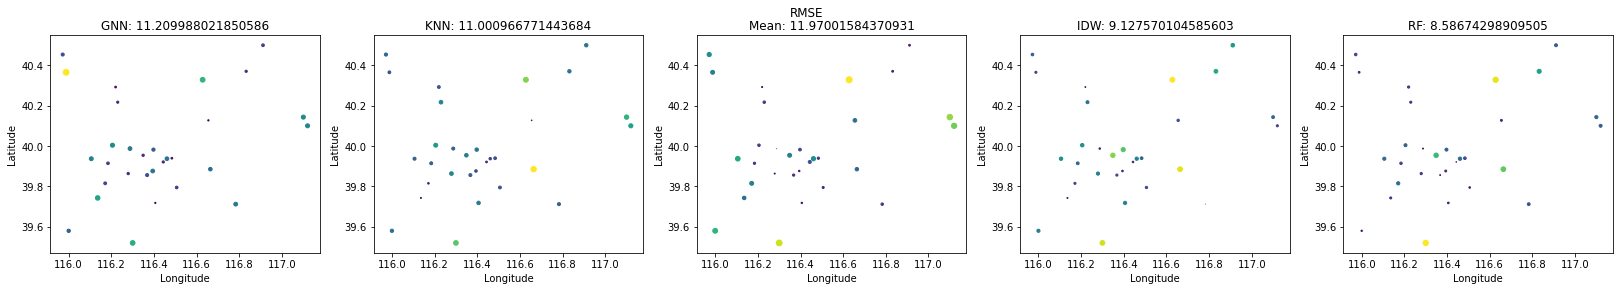

KNN RMSE:  18.84755096435547
Mean RMSE:  19.74689687093099
IDW RMSE:  18.28349284030632
RF RMSE:  16.766827041625977
LR RMSE:  18.468460591634116
GNN RMSE:  20.206352106730144


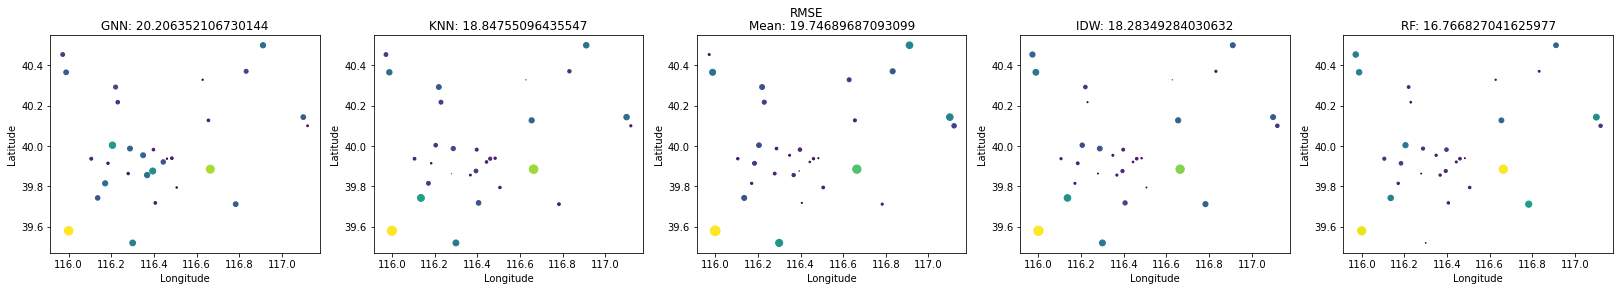

KNN RMSE:  32.89495595296224
Mean RMSE:  30.42516632080078
IDW RMSE:  34.070162568519386
RF RMSE:  28.256168143717453
LR RMSE:  34.51177164713542
GNN RMSE:  31.524207051595052


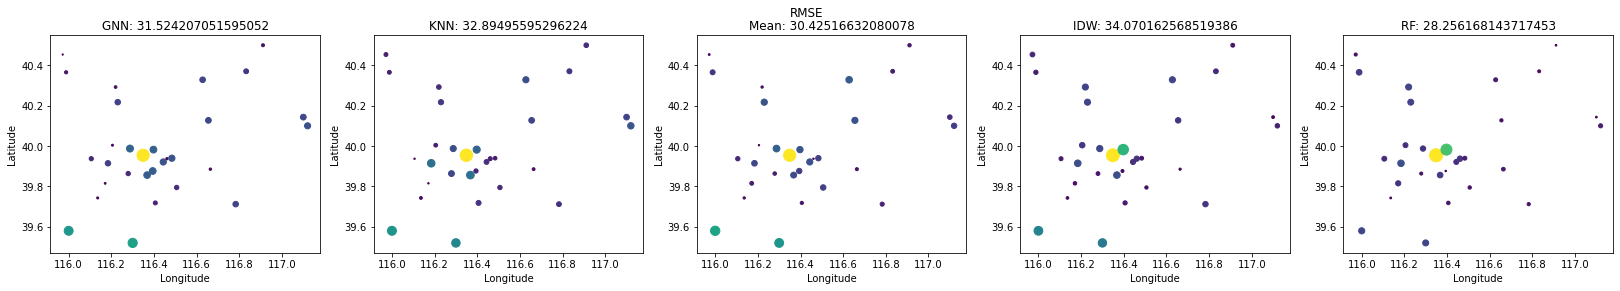

KNN RMSE:  28.958333333333332
Mean RMSE:  31.022989400227864
IDW RMSE:  21.701673045188432
RF RMSE:  22.13153333333333
LR RMSE:  27.543717447916666
GNN RMSE:  29.419651794433594


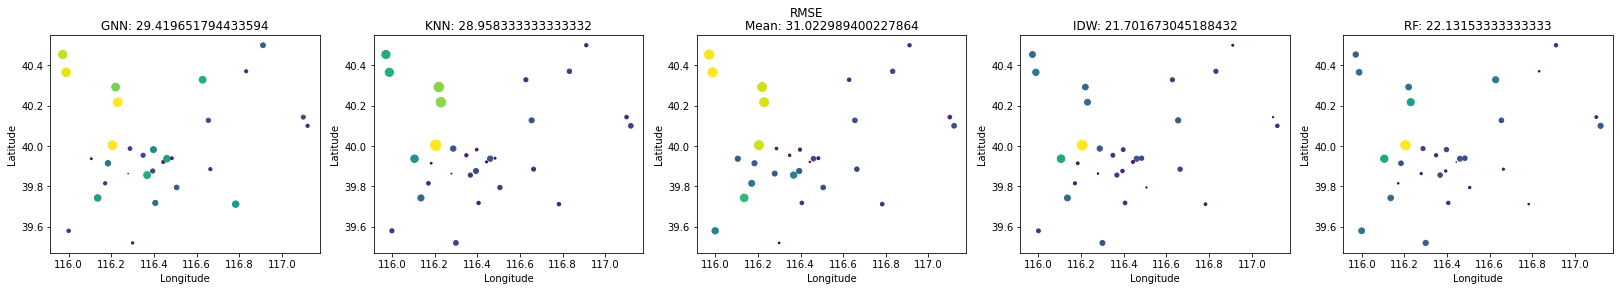

KNN RMSE:  6.708333460489909
Mean RMSE:  7.305746714274089
IDW RMSE:  5.5991224998942775
RF RMSE:  5.842844609626136
LR RMSE:  6.992250251770019
GNN RMSE:  6.475118827819824


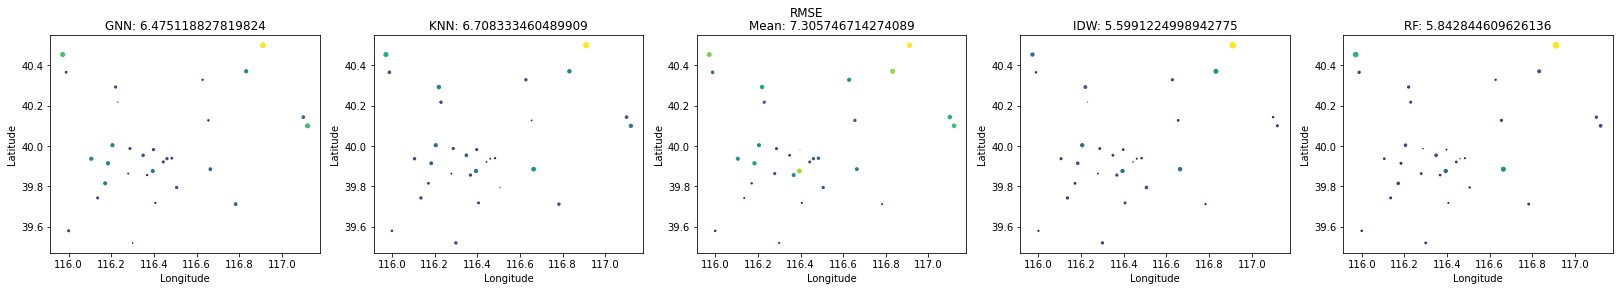

KNN RMSE:  31.738006337483725
Mean RMSE:  35.54973780314128
IDW RMSE:  29.638725580388545
RF RMSE:  26.16402531738281
LR RMSE:  27.662506357828775
GNN RMSE:  32.169141387939455


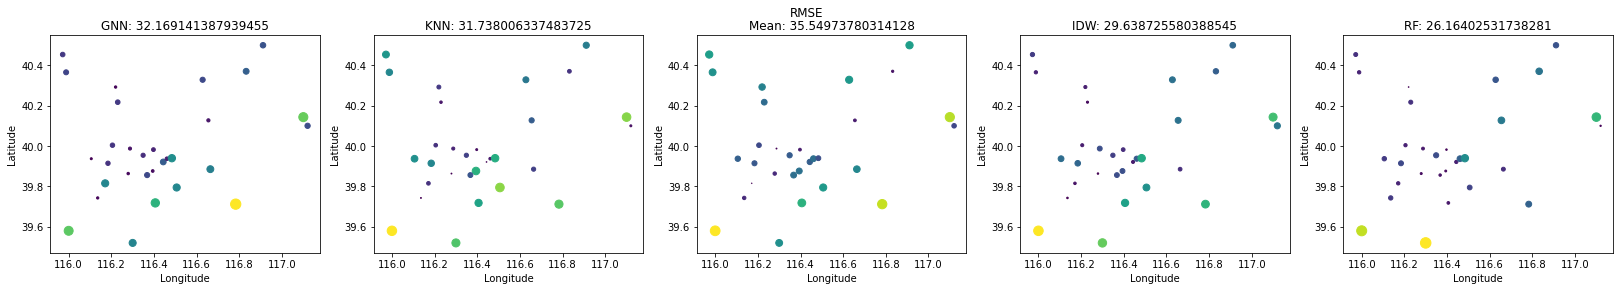

KNN RMSE:  32.87083333333333
Mean RMSE:  30.400000508626302
IDW RMSE:  36.147363935543
RF RMSE:  35.95033333333333
LR RMSE:  32.580712890625
GNN RMSE:  34.897902425130205


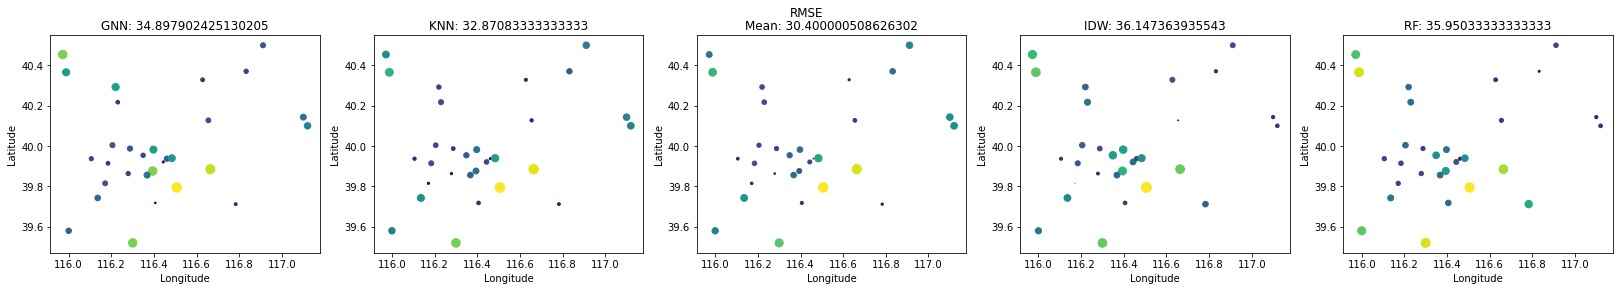

In [4]:
p = pd.date_range(start='2014-05-01 00:00:00', end='2014-12-01 00:00:00', freq = '1M').to_frame(name='dates')

for i in p['dates']:
    d_i = loocv(i)
    d_i = pd.DataFrame(d_i)
    print('KNN RMSE: ', np.mean(d_i['knn rmse']))
    print('Mean RMSE: ', np.mean(d_i['mean rmse']))
    print('IDW RMSE: ', np.mean(d_i['idw rmse']))
    print('RF RMSE: ', np.mean(d_i['rf rmse']))
    print('LR RMSE: ', np.mean(d_i['lr rmse']))
    print('GNN RMSE: ', np.mean(d_i['gnn rmse']))
    
    plt.figure(figsize = (28,4))
    plt.suptitle('RMSE')
    plt.subplot(1, 5, 1)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['gnn rmse'], c = d_i['gnn rmse'])
    title = 'GNN: ' + str(np.mean(d_i['gnn rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 2)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['knn rmse'], c = d_i['knn rmse'])
    title = 'KNN: ' + str(np.mean(d_i['knn rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 3)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['mean rmse'], c = d_i['mean rmse'])
    title = 'Mean: ' + str(np.mean(d_i['mean rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 4)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['idw rmse'], c = d_i['idw rmse'])
    title = 'IDW: ' + str(np.mean(d_i['idw rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 5)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['rf rmse'], c = d_i['rf rmse'])
    title = 'RF: ' + str(np.mean(d_i['rf rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [5]:
p['dates']

2014-05-31   2014-05-31
2014-06-30   2014-06-30
2014-07-31   2014-07-31
2014-08-31   2014-08-31
2014-09-30   2014-09-30
2014-10-31   2014-10-31
2014-11-30   2014-11-30
Freq: M, Name: dates, dtype: datetime64[ns]